In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
states = []
for i in range(12, 22):
    for j in range(1, 11):
        for k in range(2):
            states.append((i, j, k))

In [3]:
print(f"Total states: {len(states)}")

Total states: 200


In [4]:
def dealerVal(dealer_faceup_card):
    cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1]
    second_card = np.random.choice(cards)
    val = 0
    if dealer_faceup_card == 1:
        usableAce = 1
        val += 11
        val += second_card
    elif second_card == 1:
        usableAce = 1
        val += 11
        val += dealer_faceup_card
    else:
        usableAce = 0
        val = dealer_faceup_card + second_card
    
    while val < 17:
        card = np.random.choice(cards)
        
        if card + val > 21:
            if usableAce == 1:
                val = val + card - 10
            else:
                return card + val
        val += card
    return val    

In [5]:
dealerVal(12)

17

In [6]:
def envStep(state, action):
    val = state[0]
    dealer_faceup_card = state[1]
    usableAce = state[2]
    # Ace is valued as 1 as we have states for usable Aces already
    cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1]
    reward = 0
    terminated = False
    checkToggle = False
    if action == "hit" or action == 0:
        card = np.random.choice(cards)
        if card + val > 21:
            if usableAce == 1:
                val = card + val - 10
                usableAce = 0 # We don't have an usable Ace anymore!
                if val == 21:
                    checkToggle = True
            else:
                val += card
                checkToggle = True
                usableAce = 1
                terminated = True
        else:
            val = card + val

    if action == "stick" or action == 1 or checkToggle == True:
        dealer_val = dealerVal(dealer_faceup_card)
        if val == 21:
            if dealer_val == 21:
                reward = 0
            else:
                reward = 1

        elif val > 21:
            if dealer_val > 21:
                reward = 0
            else:
                reward = -1
            
        else: # Value is less than 21
            if dealer_val == 21:
                reward = -1
            if dealer_val > 21:
                reward = 1
            else: # Both dealer's and our sum is less than 21
                if val > dealer_val:
                    reward = 1
                elif val == dealer_val:
                    reward = 0
                else:
                    reward = -1
        terminated = True
        
    return (val, dealer_faceup_card, usableAce), reward, terminated


### Monte Carlo for Exploring Starts

In [7]:
QValues = np.zeros((10, 10, 2, 2))

alpha = 0.1
stateaction_counter = np.zeros((10, 10, 2, 2))
pi = np.zeros((10, 10, 2), dtype="int8")
pi[8] = np.ones((10, 2), dtype="int8")
pi[9] = np.ones((10, 2), dtype="int8")

for i in range(500000):
    reached_states = []
    state, first_action = states[np.random.randint(200)], np.random.randint(2) # 0 -> HIT and 1 -> STICK
    initial_state = state
    terminated = False
    returns = 0
    while not terminated:
        state_playeridx = state[0] - 12
        state_dealeridx = state[1] - 1
        state_aceidx = state[2]
        reached_states.append(state)
        state, reward, terminated = envStep(state, pi[state_playeridx][state_dealeridx][state_aceidx])
        returns += reward

    for state in reached_states:
        state_playeridx = state[0] - 12
        state_dealeridx = state[1] - 1
        state_aceidx = state[2]

        action = pi[state_playeridx][state_dealeridx][state_aceidx]

        if state == initial_state:
            action = first_action
        
        stateaction_counter[state_playeridx][state_dealeridx][state_aceidx] += 1
        QValues[state_playeridx][state_dealeridx][state_aceidx][action] += (returns - QValues[state_playeridx][state_dealeridx][state_aceidx][action])/stateaction_counter[state_playeridx][state_dealeridx][state_aceidx][action]

In [8]:
print(QValues.shape)
print(pi.shape)

(10, 10, 2, 2)
(10, 10, 2)


In [9]:
Values = np.zeros((10, 10, 2))
for state in states:
    state_playeridx = state[0] - 12
    state_dealeridx = state[1] - 1
    state_aceidx = state[2]

    action = pi[state_playeridx][state_dealeridx][state_aceidx]
    Values[state_playeridx][state_dealeridx][state_aceidx] = QValues[state_playeridx][state_dealeridx][state_aceidx][action]

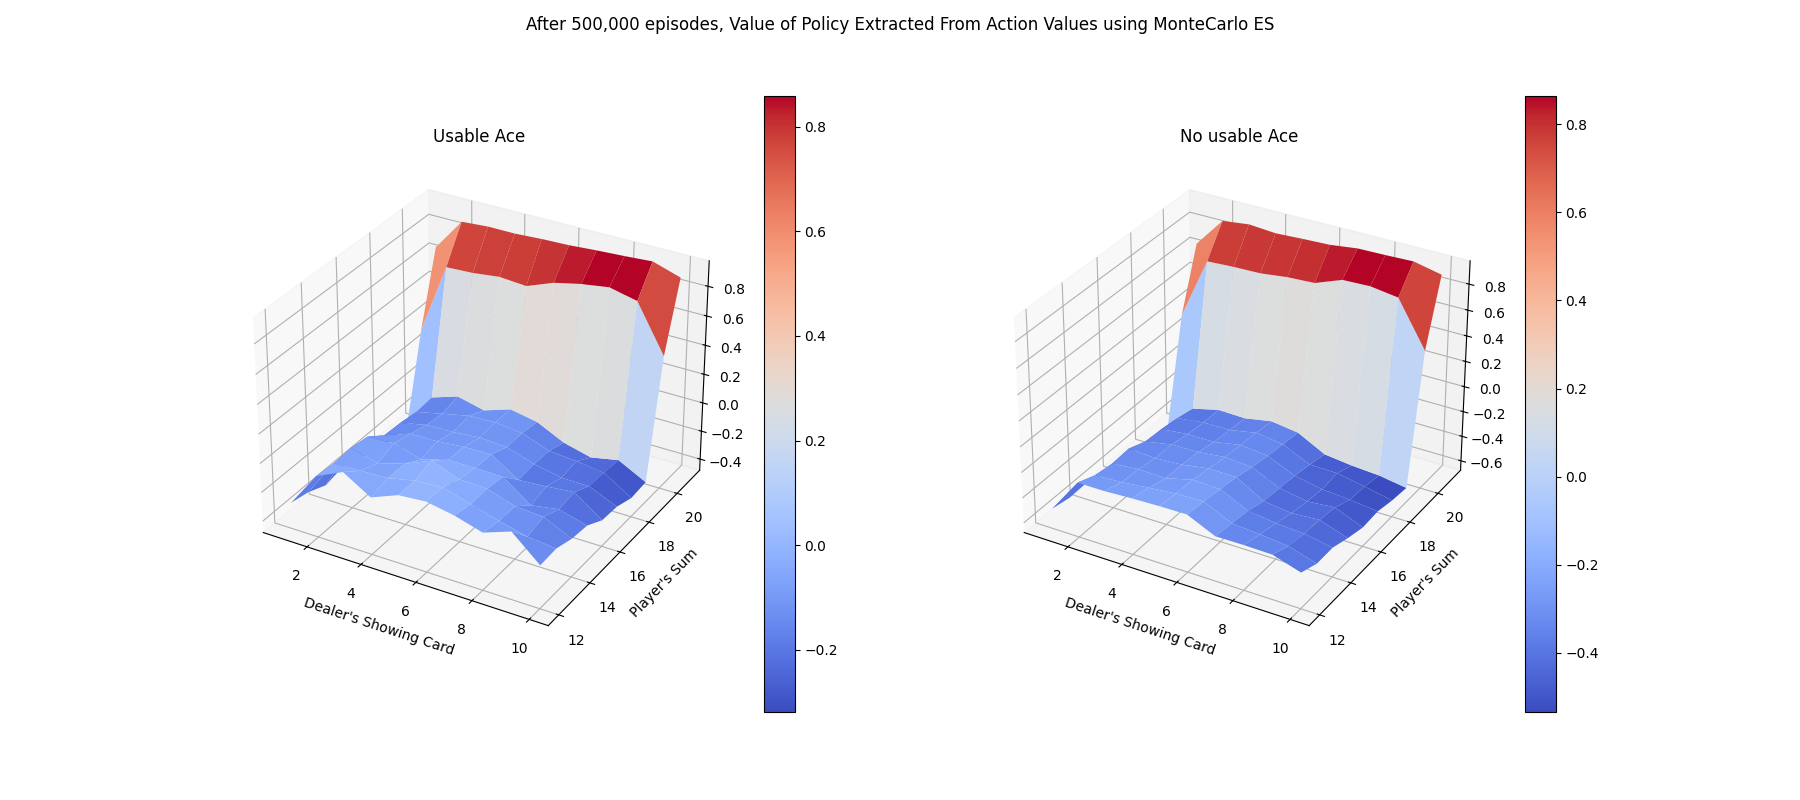

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": "3d"})
fig.suptitle("After 500,000 episodes, Value of Policy Extracted From Action Values using MonteCarlo ES")
for ax in axes.flatten():
    ax.set_xlabel("Dealer's Showing Card")
    ax.set_ylabel("Player's Sum")
axes[0].set_title("Usable Ace")
axes[1].set_title("No usable Ace")
x = np.arange(1, 11)
y = np.arange(12, 22)
x, y = np.meshgrid(x, y)
a = axes[0].plot_surface(x, y, Values[:, :, 1], cmap='coolwarm')
b = axes[1].plot_surface(x, y, Values[:, :, 0], cmap='coolwarm')
fig.colorbar(a)
fig.colorbar(b)

### Finding Optimal Policy and Action Values

In [26]:
QValues = np.zeros((10, 10, 2, 2))

alpha = 0.1
stateaction_counter = np.zeros((10, 10, 2, 2))
pi = np.zeros((10, 10, 2), dtype="int8")
pi[8] = np.ones((10, 2), dtype="int8")
pi[9] = np.ones((10, 2), dtype="int8")

for iter in range(100):
    # Evaluate pi
    for i in range(100000):
        reached_states = []
        state, first_action = states[np.random.randint(200)], np.random.randint(2) # 0 -> HIT and 1 -> STICK
        initial_state = state
        terminated = False
        returns = 0
        while not terminated:
            state_playeridx = state[0] - 12
            state_dealeridx = state[1] - 1
            state_aceidx = state[2]
            reached_states.append(state)
            state, reward, terminated = envStep(state, pi[state_playeridx][state_dealeridx][state_aceidx])
            returns += reward

        for state in reached_states:
            state_playeridx = state[0] - 12
            state_dealeridx = state[1] - 1
            state_aceidx = state[2]

            action = pi[state_playeridx][state_dealeridx][state_aceidx]

            if state == initial_state:
                action = first_action
            
            stateaction_counter[state_playeridx][state_dealeridx][state_aceidx] += 1
            QValues[state_playeridx][state_dealeridx][state_aceidx][action] += (returns - QValues[state_playeridx][state_dealeridx][state_aceidx][action])/stateaction_counter[state_playeridx][state_dealeridx][state_aceidx][action]
            
    # Improving Policy
    policy_stable = True
    for state in states:
        state_playeridx = state[0] - 12
        state_dealeridx = state[1] - 1
        state_aceidx = state[2]
        optimal_action = np.argmax(QValues[state_playeridx, state_dealeridx, state_aceidx])
        policy_action = pi[state_playeridx, state_dealeridx, state_aceidx]
        if optimal_action != policy_action:
            policy_stable = False
            pi[state_playeridx, state_dealeridx, state_aceidx] = optimal_action
    # if policy_stable:
    #     break

In [27]:
OptimalValues = np.zeros((10, 10, 2))
for state in states:
    state_playeridx = state[0] - 12
    state_dealeridx = state[1] - 1
    state_aceidx = state[2]

    action = pi[state_playeridx][state_dealeridx][state_aceidx]
    OptimalValues[state_playeridx][state_dealeridx][state_aceidx] = QValues[state_playeridx][state_dealeridx][state_aceidx][action]

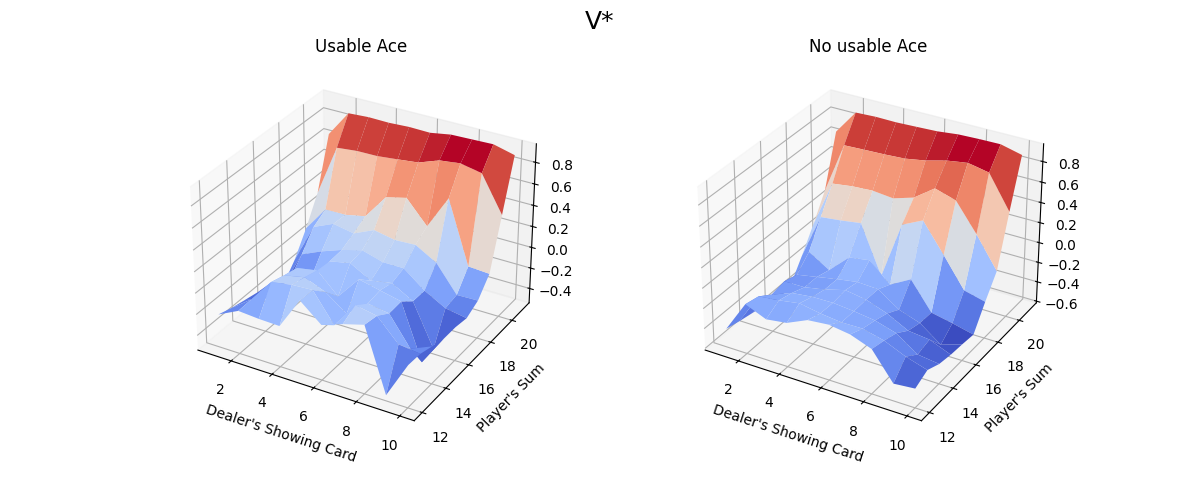

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
fig.suptitle("V*", fontsize=18)
for ax in axes.flatten():
    ax.set_xlabel("Dealer's Showing Card")
    ax.set_ylabel("Player's Sum")
axes[0].set_title("Usable Ace")
axes[1].set_title("No usable Ace")
x = np.arange(1, 11)
y = np.arange(12, 22)
x, y = np.meshgrid(x, y)
axes[0].plot_surface(x, y, OptimalValues[:, :, 1], cmap='coolwarm')
axes[1].plot_surface(x, y, OptimalValues[:, :, 0], cmap='coolwarm')

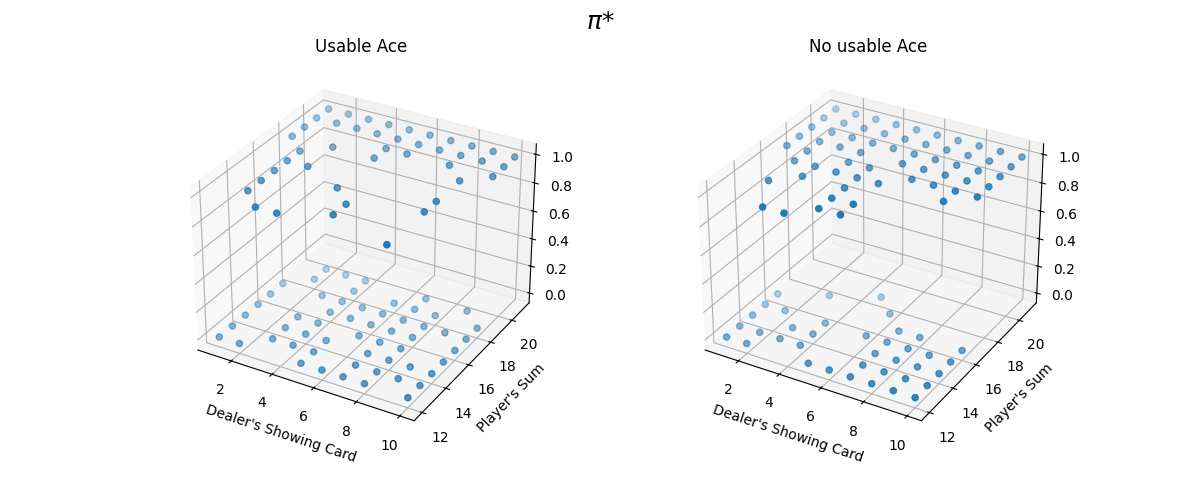

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection":"3d"})
fig.suptitle("$\pi$*", fontsize=18)
for ax in axes.flatten():
    ax.set_xlabel("Dealer's Showing Card")
    ax.set_ylabel("Player's Sum")
axes[0].set_title("Usable Ace")
axes[1].set_title("No usable Ace")
x = np.arange(1, 11)
y = np.arange(12, 22)
x, y = np.meshgrid(x, y)
# axes[0].contour(x, y, pi[:, :, 1], levels=[0, 1], cmap="coolwarm")
# axes[1].contour(x, y, pi[:, :, 0], levels=[0, 1], cmap="coolwarm")

axes[0].scatter(x, y, pi[:, :, 1])
axes[1].scatter(x, y, pi[:, :, 0])